# Floaty MLP
#### Alessandro Di Giorgio, MPI-IS Tübingen, 15/10/25

## Import the acquired data and define an evaluation function for testing
Obtained by means of several runs on different input trajectories

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

def load_floaty_full_data(file_path):
    """
    Loads the Floaty dataset from a .csv file and returns:
    - All relevant data concatenated in columns (excluding accelerations)
    - Individual arrays for reference
    """

    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")

    # Extract data by column name patterns
    lin_pos = df[[col for col in df.columns if col.startswith("lin_pos_")]].to_numpy()
    lin_vel = df[[col for col in df.columns if col.startswith("lin_vel_")]].to_numpy()
    lin_acc = df[[col for col in df.columns if col.startswith("lin_acc_")]].to_numpy()
    angles  = df[[col for col in df.columns if col.startswith("angle_")]].to_numpy()
    ang_rate = df[[col for col in df.columns if col.startswith("ang_rate_")]].to_numpy()
    ang_acc = df[[col for col in df.columns if col.startswith("ang_acc_")]].to_numpy()
    U = df[[col for col in df.columns if col.startswith("U_")]].to_numpy()

    # Concatenate only the desired columns (exclude accelerations)
    concatenated = np.concatenate([lin_pos, lin_vel, angles, ang_rate], axis=1)

    print(f"Concatenated data shape (without accelerations): {concatenated.shape}")

    return lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, concatenated


# Example usage
file_path = 'estimated_data2.csv'
experiment_params = {}
experiment_params['data_file'] = file_path # in case more datasets are loaded and merged, I will insert manually a string
lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, X = load_floaty_full_data(file_path)

# Compute ΔX[t] = X[t+1] - X[t]
Y = X[1:] - X[:-1]
X = X[:-1]
U = U[:-1]
# Training input
Z = np.concatenate([X,U], axis=1)

print(f"Training inputs shape: {Z.shape}, targets shape: {Y.shape}")


def test_keras_model_grouped(model_path, X_test, Y_test, sc_out, plot_dim=12):
    """
    Tests a trained Keras model on the test dataset.
    Shows detailed metrics grouped by 3-column physical groups and separate plots for each output.
    """

    # --- Load model ---
    model = load_model(model_path)
    print(f"Loaded model from: {model_path}")

    #model = model

    # --- Predict ---
    Y_pred = model.predict(X_test, verbose=0)

    # --- Denormalize predictions and ground truth ---
    Y_pred_phys = sc_out.inverse_transform(Y_pred)
    Y_true_phys = sc_out.inverse_transform(Y_test)

    # --- Compute overall metrics ---
    mse = mean_squared_error(Y_true_phys, Y_pred_phys)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_true_phys, Y_pred_phys)
    r2 = r2_score(Y_true_phys, Y_pred_phys)
    print("\n--- Overall Test Metrics ---")
    print(pd.DataFrame([{"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}]))

    # --- Define variable and group names ---
    var_names = ["Δx", "Δy", "Δz",
                 "Δvx", "Δvy", "Δvz",
                 "Δroll", "Δpitch", "Δyaw",
                 "Δp", "Δq", "Δr"]

    group_names = ["Linear Position", "Linear Velocity", "Angles", "Angular Rates"]

    # --- Compute metrics per group ---
    group_metrics = []
    for g in range(4):
        start, end = g * 3, (g + 1) * 3
        Yt_g = Y_true_phys[:, start:end]
        Yp_g = Y_pred_phys[:, start:end]
        mse_g = mean_squared_error(Yt_g, Yp_g)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(Yt_g, Yp_g)
        r2_g = r2_score(Yt_g, Yp_g)
        group_metrics.append([group_names[g], mse_g, rmse_g, mae_g, r2_g])

    df_groups = pd.DataFrame(group_metrics, columns=["Group", "MSE", "RMSE", "MAE", "R2"])

    print("\n--- Metrics by Group ---")
    print(df_groups.to_string(index=False, justify="center", float_format=lambda x: f"{x:10.6f}"))

    # --- Plot each output dimension separately ---
    n_plots = min(plot_dim, Y_true_phys.shape[1])
    for i in range(n_plots):
        plt.figure(figsize=(10, 4))
        plt.plot(Y_true_phys[:200, i], label='True', linewidth=2)
        plt.plot(Y_pred_phys[:200, i], label='Pred', linestyle='--')
        plt.title(f"{var_names[i]} ({group_names[i//3]})")
        plt.xlabel("Sample index")
        plt.ylabel(var_names[i])
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"overall": {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2},
            "groups": df_groups}

Loaded dataset with shape: (14900, 22)
Concatenated data shape (without accelerations): (14900, 12)
Training inputs shape: (14899, 16), targets shape: (14899, 12)


## Dataset shuffling, normalization and splitting

In [3]:
def prepare_dataset( #not shuffling at all any set
    X_all, U_all, Y_all, val_ratio=0.1, test_ratio=0.1, random_seed=None
):
    """
    - Chronological split:
        → TRAIN = first part
        → VAL   = middle part
        → TEST  = last part (ordered)
    - Fit scalers ONLY on TRAIN subset
    - Keep an ordered TEST copy (for rollout)
    """

    # ----- Concatenate inputs -----
    X_in = np.hstack([X_all, U_all])   # shape (N, n_x + n_u)
    Y_out = Y_all                      # shape (N, n_y)
    N = len(X_in)

    # ----- Compute split sizes -----
    n_test = int(test_ratio * N)
    n_val  = int(val_ratio  * N)
    n_train = N - n_val - n_test
    if n_train <= 0:
        raise ValueError("Not enough samples for training. Reduce val_ratio/test_ratio.")

    # ----- Chronological splits -----
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n_train + n_val)
    idx_test  = np.arange(n_train + n_val, N)

    # ----- Fit scalers ONLY on TRAIN subset -----
    sc_in  = StandardScaler().fit(X_in[idx_train])
    sc_out = StandardScaler().fit(Y_out[idx_train])

    # ----- Transform all splits -----
    X_train, Y_train = sc_in.transform(X_in[idx_train]), sc_out.transform(Y_out[idx_train])
    X_val,   Y_val   = sc_in.transform(X_in[idx_val]),   sc_out.transform(Y_out[idx_val])
    X_test,  Y_test  = sc_in.transform(X_in[idx_test]),  sc_out.transform(Y_out[idx_test])

    X_test_ord = X_test.copy()
    Y_test_ord = Y_test.copy()

    # ----- Info -----
    print("Scalers fit on TRAIN subset only (no data leakage).")
    print("Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout")
    print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    return (
        X_train, Y_train,           # non-shuffled train
        X_val, Y_val,               # non-shuffled val
        X_test, Y_test,             # non-shuffled test (for general training)
        X_test_ord, Y_test_ord,
        sc_in, sc_out
    )


# ----- Example usage -----
(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,                 # shuffled test (for training)
    X_test_ord, Y_test_ord,                 
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1, random_seed=42
)


random_seed = 42


(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,
    X_test_ord, Y_test_ord,
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1,
    random_seed=random_seed
)

Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout
Shapes -> X_train: (11921, 16), X_val: (1489, 16), X_test: (1489, 16)
Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST shuffled, saved a copy of unshufled test set for rollout
Shapes -> X_train: (11921, 16), X_val: (1489, 16), X_test: (1489, 16)


## MLP
We use tanh because, even if carries with itslef some defects, helps not to smooth out the derivatives and so keeps the system more aderent to reality. A simple 4-layer MLP with small weight matrices is enough to fully capture the features of our system

In [25]:
# Learning parameters
lr = 1e-3
epochs = 600
batch_size = 128

experiment_params['lr'] = lr
experiment_params['epochs'] = epochs
experiment_params['batch_size'] = batch_size

# MLP (actually, I removed residual connections)
inputs = keras.Input(shape=(X_train.shape[1],))

# First block
x = layers.Dense(16, activation='tanh')(inputs)

# # Final layers
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(Y_train.shape[1])(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile
model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

layer_sizes = [layer.units for layer in model.layers if hasattr(layer, "units")]
print(layer_sizes)




[16, 12]


## Model Training


🟢 Training up to 5 / 100 epochs...

Epoch 1/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 1.3206 
Epoch 1: val_loss improved from None to 0.81227, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0421 - val_loss: 0.8123 - learning_rate: 0.0010
Epoch 2/5
44/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7241 
Epoch 2: val_loss improved from 0.81227 to 0.59304, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6390 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 3/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.5432
Epoch 3: val_loss improved from 0.59304 to 0.49465, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4985 - val_loss: 0.4946 - learning_rate: 0.0010
Epoch 4/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.4567
Epoch 4: val_loss improved from 0.49465 to 0.43738, saving model to checkpoints/best_model_until

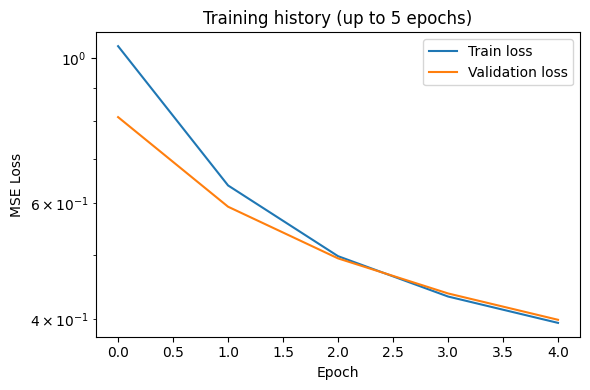


🔍 Evaluating model after 5 epochs...
Loaded model from: checkpoints\model_epoch_5.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.040556  0.201385  0.083641  0.618997

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000002   0.001415   0.000979   0.897597
Linear Velocity   0.000436   0.020872   0.015744   0.421491
         Angles   0.000168   0.012959   0.009998   0.847956
  Angular Rates   0.161618   0.402017   0.307843   0.308943
📊 Logged metrics: Epoch 5 | MSE = 4.055577e-02, R2 = 0.618997

🟢 Training up to 10 / 100 epochs...

Epoch 1/5
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.3667
Epoch 1: val_loss improved from None to 0.37067, saving model to checkpoints/best_model_until_10.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3678 - val_loss: 0.3707 - learning_rate: 0.0010
Epoch 2/5
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.3568
Epoch 2: val_loss improved from 0.37067

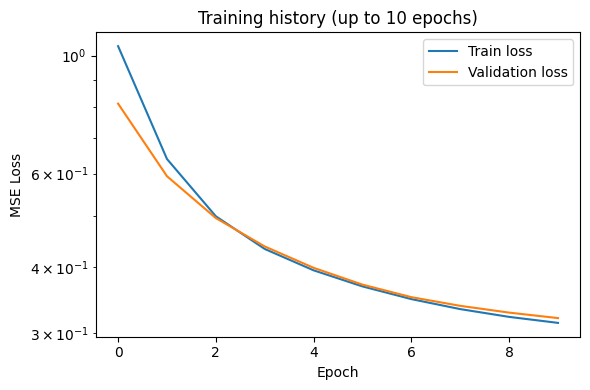


🔍 Evaluating model after 10 epochs...
Loaded model from: checkpoints\model_epoch_10.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.037798  0.194418  0.079967  0.684739

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000001   0.000933   0.000623   0.955186
Linear Velocity   0.000352   0.018754   0.014223   0.491016
         Angles   0.000065   0.008091   0.005871   0.945591
  Angular Rates   0.150776   0.388299   0.299149   0.347164
📊 Logged metrics: Epoch 10 | MSE = 3.779850e-02, R2 = 0.684739

🟢 Training up to 15 / 100 epochs...

Epoch 1/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.3066
Epoch 1: val_loss improved from None to 0.31636, saving model to checkpoints/best_model_until_15.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3077 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 2/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.2926
Epoch 2: val_loss improved from 0.31

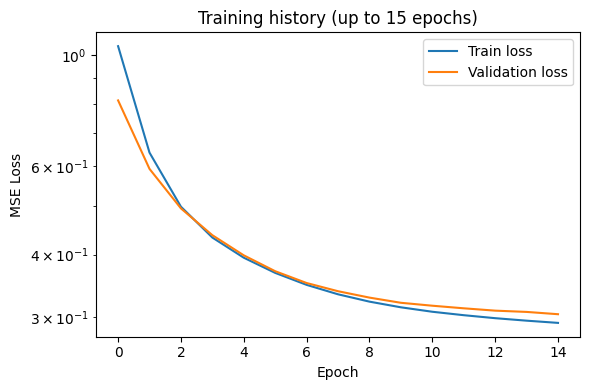


🔍 Evaluating model after 15 epochs...
Loaded model from: checkpoints\model_epoch_15.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.037039  0.192456  0.078851  0.699237

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000001   0.000707   0.000476   0.970560
Linear Velocity   0.000339   0.018417   0.014042   0.499457
         Angles   0.000045   0.006695   0.004906   0.963643
  Angular Rates   0.147772   0.384412   0.295981   0.363287
📊 Logged metrics: Epoch 15 | MSE = 3.703924e-02, R2 = 0.699237

🟢 Training up to 20 / 100 epochs...

Epoch 1/5
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.2947
Epoch 1: val_loss improved from None to 0.30326, saving model to checkpoints/best_model_until_20.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2897 - val_loss: 0.3033 - learning_rate: 0.0010
Epoch 2/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.2917
Epoch 2: val_loss improved from 0.30

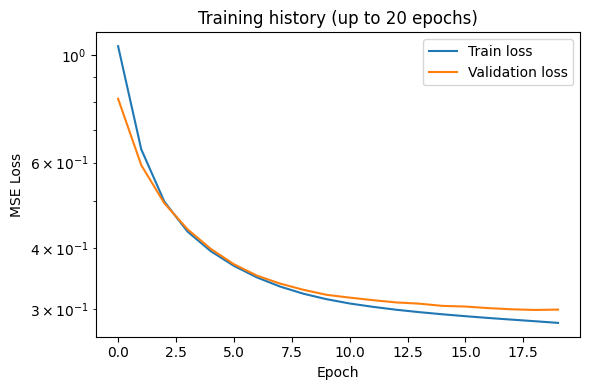


🔍 Evaluating model after 20 epochs...
Loaded model from: checkpoints\model_epoch_20.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.036332  0.190609  0.078095  0.707462

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000647   0.000442   0.973274
Linear Velocity   0.000335   0.018293   0.013986   0.509273
         Angles   0.000039   0.006274   0.004636   0.968115
  Angular Rates   0.144953   0.380727   0.293314   0.379187
📊 Logged metrics: Epoch 20 | MSE = 3.633187e-02, R2 = 0.707462

🟢 Training up to 25 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.2855
Epoch 1: val_loss improved from None to 0.29708, saving model to checkpoints/best_model_until_25.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2787 - val_loss: 0.2971 - learning_rate: 0.0010
Epoch 2/5
64/93 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.2805
Epoch 2: val_loss improved from 0.29

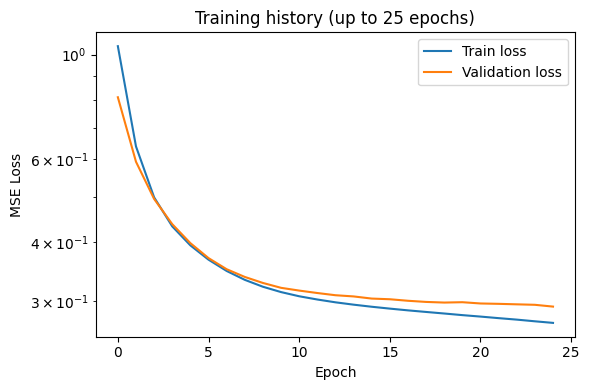


🔍 Evaluating model after 25 epochs...
Loaded model from: checkpoints\model_epoch_25.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.035503  0.188422  0.07705  0.715392

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000644   0.000445   0.971734
Linear Velocity   0.000330   0.018152   0.013900   0.522418
         Angles   0.000039   0.006250   0.004629   0.968466
  Angular Rates   0.141643   0.376354   0.289225   0.398952
📊 Logged metrics: Epoch 25 | MSE = 3.550292e-02, R2 = 0.715392

🟢 Training up to 30 / 100 epochs...

Epoch 1/5
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.2721
Epoch 1: val_loss improved from None to 0.29290, saving model to checkpoints/best_model_until_30.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2683 - val_loss: 0.2929 - learning_rate: 0.0010
Epoch 2/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.2653
Epoch 2: val_loss did not improve from

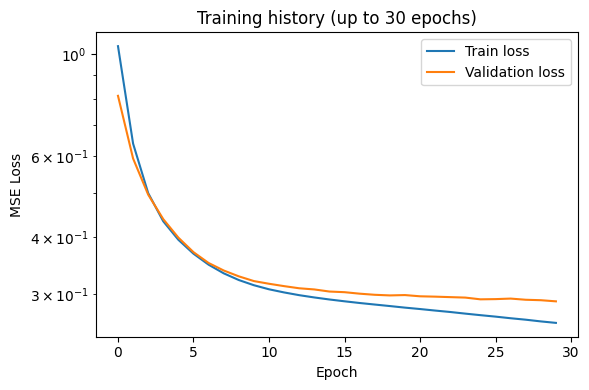


🔍 Evaluating model after 30 epochs...
Loaded model from: checkpoints\model_epoch_30.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.034609  0.186034  0.075942  0.722932

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000664   0.000457   0.970966
Linear Velocity   0.000327   0.018073   0.013845   0.537193
         Angles   0.000039   0.006263   0.004681   0.967926
  Angular Rates   0.138068   0.371575   0.284785   0.415645
📊 Logged metrics: Epoch 30 | MSE = 3.460857e-02, R2 = 0.722932

🟢 Training up to 35 / 100 epochs...

Epoch 1/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.2640
Epoch 1: val_loss improved from None to 0.28865, saving model to checkpoints/best_model_until_35.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2580 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 2/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.2538
Epoch 2: val_loss improved from 0.28

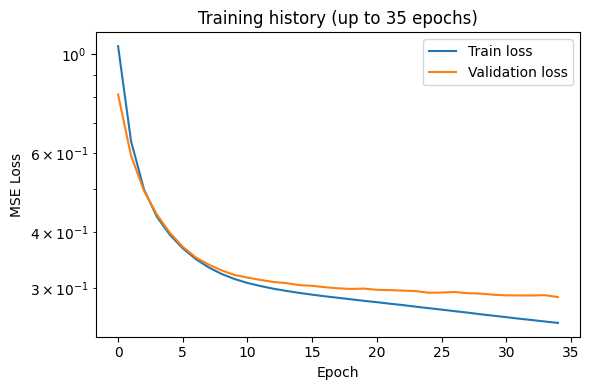


🔍 Evaluating model after 35 epochs...
Loaded model from: checkpoints\model_epoch_35.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.033143  0.182052  0.074415  0.731103

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000001   0.000709   0.000485   0.970401
Linear Velocity   0.000327   0.018078   0.013845   0.545336
         Angles   0.000039   0.006275   0.004691   0.967930
  Angular Rates   0.132205   0.363600   0.278641   0.440743
📊 Logged metrics: Epoch 35 | MSE = 3.314296e-02, R2 = 0.731103

🟢 Training up to 40 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.2591
Epoch 1: val_loss improved from None to 0.28414, saving model to checkpoints/best_model_until_40.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2487 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 2/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.2509
Epoch 2: val_loss did not improve fr

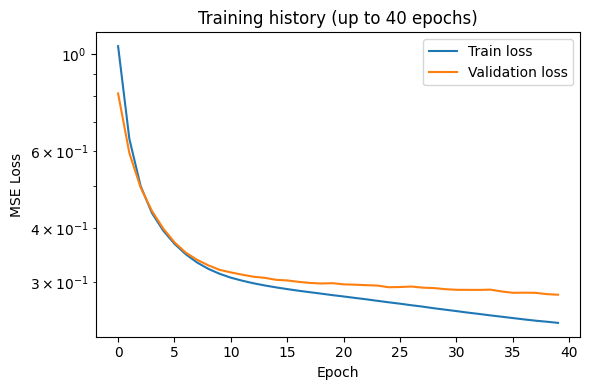


🔍 Evaluating model after 40 epochs...
Loaded model from: checkpoints\model_epoch_40.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.032265  0.179625  0.073511  0.738641

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000700   0.000477   0.971582
Linear Velocity   0.000322   0.017953   0.013747   0.558086
         Angles   0.000037   0.006073   0.004526   0.970078
  Angular Rates   0.128700   0.358748   0.275296   0.454818
📊 Logged metrics: Epoch 40 | MSE = 3.226497e-02, R2 = 0.738641

🟢 Training up to 45 / 100 epochs...

Epoch 1/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.2477
Epoch 1: val_loss improved from None to 0.28013, saving model to checkpoints/best_model_until_45.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2410 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 2/5
63/93 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.2430
Epoch 2: val_loss improved from 0.28

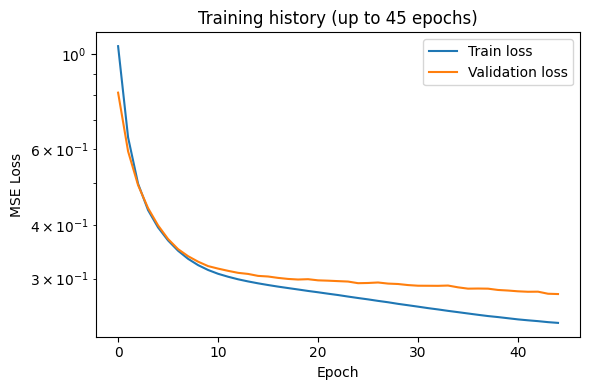


🔍 Evaluating model after 45 epochs...
Loaded model from: checkpoints\model_epoch_45.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.031479  0.177424  0.072604  0.744295

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000670   0.000458   0.973878
Linear Velocity   0.000319   0.017850   0.013700   0.561693
         Angles   0.000035   0.005888   0.004342   0.972262
  Angular Rates   0.125563   0.354349   0.271916   0.469348
📊 Logged metrics: Epoch 45 | MSE = 3.147924e-02, R2 = 0.744295

🟢 Training up to 50 / 100 epochs...

Epoch 1/5
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2373
Epoch 1: val_loss improved from None to 0.27432, saving model to checkpoints/best_model_until_50.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2357 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.2311
Epoch 2: val_loss did not improve from

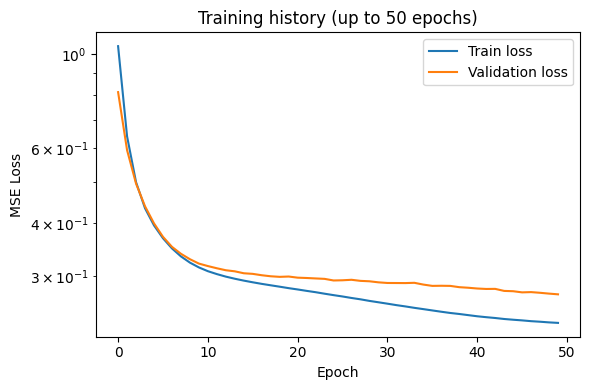


🔍 Evaluating model after 50 epochs...
Loaded model from: checkpoints\model_epoch_50.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.031026  0.176141  0.072247  0.749983

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000630   0.000432   0.977083
Linear Velocity   0.000317   0.017798   0.013636   0.571704
         Angles   0.000032   0.005650   0.004183   0.974387
  Angular Rates   0.123754   0.351787   0.270737   0.476760
📊 Logged metrics: Epoch 50 | MSE = 3.102572e-02, R2 = 0.749983

🟢 Training up to 55 / 100 epochs...

Epoch 1/5
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.2189
Epoch 1: val_loss improved from None to 0.27186, saving model to checkpoints/best_model_until_55.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2321 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 2/5
63/93 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.2321
Epoch 2: val_loss improved from 0.27

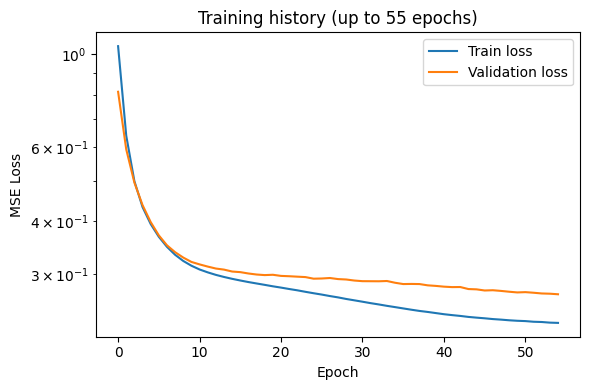


🔍 Evaluating model after 55 epochs...
Loaded model from: checkpoints\model_epoch_55.keras

--- Overall Test Metrics ---
       MSE     RMSE       MAE        R2
0  0.03079  0.17547  0.071963  0.752084

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000629   0.000431   0.977797
Linear Velocity   0.000316   0.017784   0.013630   0.574176
         Angles   0.000030   0.005504   0.004084   0.975780
  Angular Rates   0.122812   0.350446   0.269707   0.480585
📊 Logged metrics: Epoch 55 | MSE = 3.078984e-02, R2 = 0.752084

🟢 Training up to 60 / 100 epochs...

Epoch 1/5
65/93 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.2286
Epoch 1: val_loss improved from None to 0.26891, saving model to checkpoints/best_model_until_60.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2294 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 2/5
64/93 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.2267
Epoch 2: val_loss improved from 0.26891 

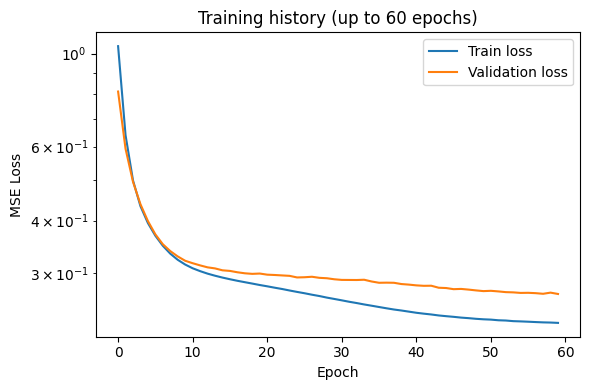


🔍 Evaluating model after 60 epochs...
Loaded model from: checkpoints\model_epoch_60.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030619  0.174984  0.071731  0.754325

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000600   0.000411   0.979994
Linear Velocity   0.000314   0.017721   0.013616   0.576200
         Angles   0.000029   0.005397   0.003999   0.976715
  Angular Rates   0.122134   0.349477   0.268899   0.484391
📊 Logged metrics: Epoch 60 | MSE = 3.061947e-02, R2 = 0.754325

🟢 Training up to 65 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.2309
Epoch 1: val_loss improved from None to 0.26776, saving model to checkpoints/best_model_until_65.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2274 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 2/5
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.2236
Epoch 2: val_loss improved from 0.26

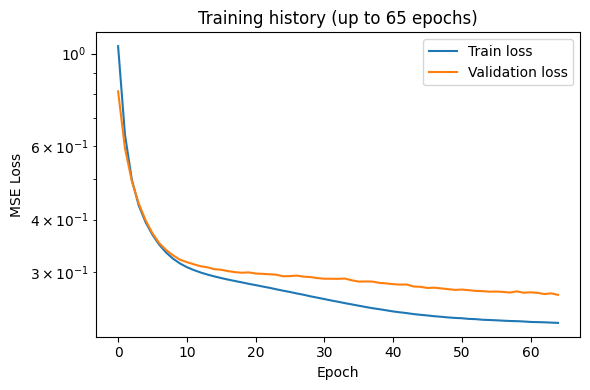


🔍 Evaluating model after 65 epochs...
Loaded model from: checkpoints\model_epoch_65.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030384  0.174309  0.071488  0.756911

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000598   0.000407   0.980720
Linear Velocity   0.000311   0.017624   0.013527   0.581227
         Angles   0.000027   0.005232   0.003897   0.977905
  Angular Rates   0.121197   0.348133   0.268121   0.487793
📊 Logged metrics: Epoch 65 | MSE = 3.038376e-02, R2 = 0.756911

🟢 Training up to 70 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.2257
Epoch 1: val_loss improved from None to 0.26296, saving model to checkpoints/best_model_until_70.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2261 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.2176
Epoch 2: val_loss did not improve fr

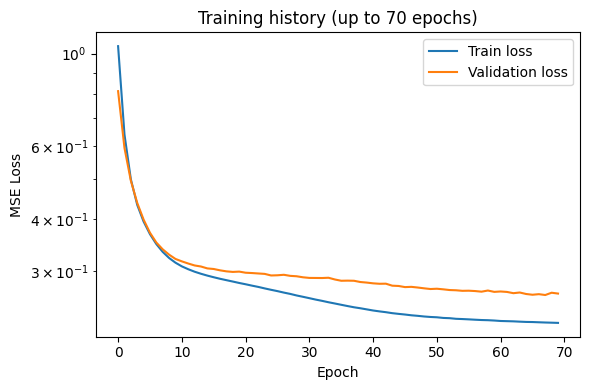


🔍 Evaluating model after 70 epochs...
Loaded model from: checkpoints\model_epoch_70.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030328  0.174148  0.071431  0.757216

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000584   0.000399   0.981440
Linear Velocity   0.000316   0.017787   0.013615   0.577345
         Angles   0.000026   0.005121   0.003831   0.978865
  Angular Rates   0.120968   0.347804   0.267878   0.491214
📊 Logged metrics: Epoch 70 | MSE = 3.032764e-02, R2 = 0.757216

🟢 Training up to 75 / 100 epochs...

Epoch 1/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.2185
Epoch 1: val_loss improved from None to 0.26404, saving model to checkpoints/best_model_until_75.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2249 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 2/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.2174
Epoch 2: val_loss improved from 0.26

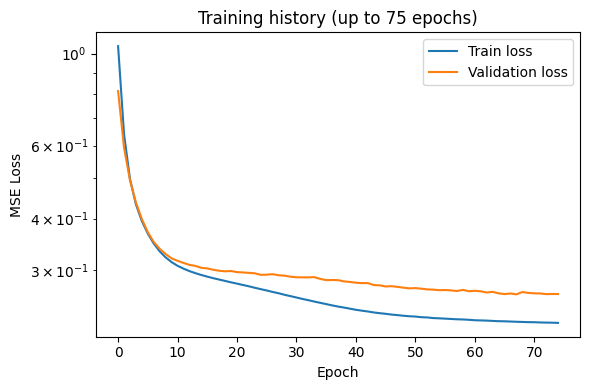


🔍 Evaluating model after 75 epochs...
Loaded model from: checkpoints\model_epoch_75.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030219  0.173836  0.071389  0.757453

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000589   0.000398   0.981803
Linear Velocity   0.000312   0.017673   0.013561   0.579161
         Angles   0.000026   0.005075   0.003792   0.979256
  Angular Rates   0.120537   0.347185   0.267804   0.489593
📊 Logged metrics: Epoch 75 | MSE = 3.021896e-02, R2 = 0.757453

🟢 Training up to 80 / 100 epochs...

Epoch 1/5
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2114 
Epoch 1: val_loss improved from None to 0.26160, saving model to checkpoints/best_model_until_80.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2239 - val_loss: 0.2616 - learning_rate: 0.0010
Epoch 2/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.2236
Epoch 2: val_loss did not improve fro

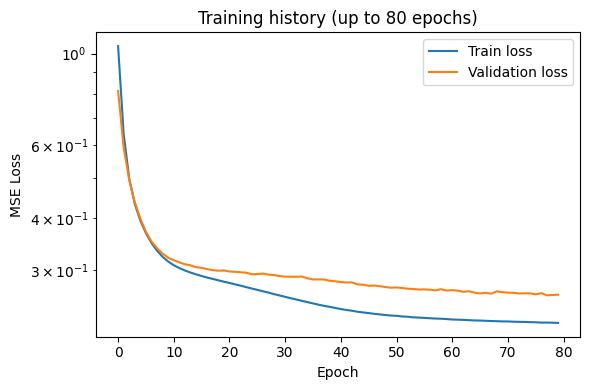


🔍 Evaluating model after 80 epochs...
Loaded model from: checkpoints\model_epoch_80.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030309  0.174095  0.071389  0.759052

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000570   0.000389   0.982981
Linear Velocity   0.000311   0.017624   0.013543   0.581707
         Angles   0.000025   0.004984   0.003742   0.979878
  Angular Rates   0.120901   0.347708   0.267882   0.491642
📊 Logged metrics: Epoch 80 | MSE = 3.030924e-02, R2 = 0.759052

🟢 Training up to 85 / 100 epochs...

Epoch 1/5
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.2202
Epoch 1: val_loss improved from None to 0.26006, saving model to checkpoints/best_model_until_85.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2230 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 2/5
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.2274
Epoch 2: val_loss did not improve fr

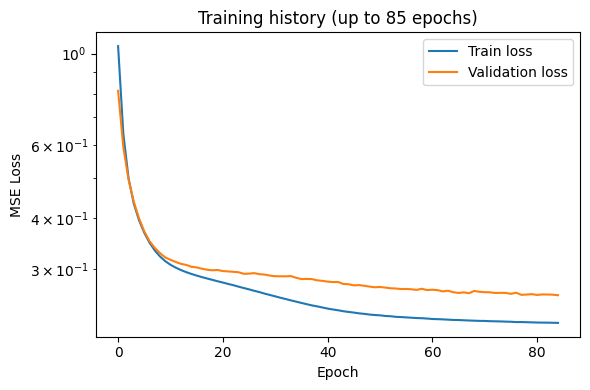


🔍 Evaluating model after 85 epochs...
Loaded model from: checkpoints\model_epoch_85.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.03007  0.173406  0.071045  0.761195

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000563   0.000379   0.983907
Linear Velocity   0.000303   0.017413   0.013367   0.586796
         Angles   0.000024   0.004946   0.003703   0.980120
  Angular Rates   0.119951   0.346340   0.266729   0.493958
📊 Logged metrics: Epoch 85 | MSE = 3.006977e-02, R2 = 0.761195

🟢 Training up to 90 / 100 epochs...

Epoch 1/5
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.2253
Epoch 1: val_loss improved from None to 0.26204, saving model to checkpoints/best_model_until_90.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2223 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.2185
Epoch 2: val_loss improved from 0.2620

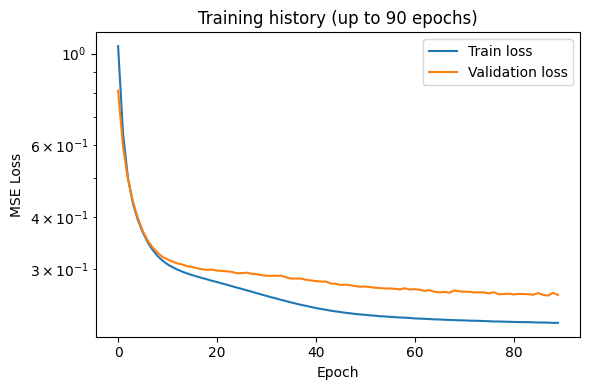


🔍 Evaluating model after 90 epochs...
Loaded model from: checkpoints\model_epoch_90.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030391  0.174329  0.071383  0.759867

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000551   0.000369   0.984585
Linear Velocity   0.000305   0.017464   0.013388   0.585094
         Angles   0.000024   0.004876   0.003654   0.980799
  Angular Rates   0.121233   0.348186   0.268119   0.488988
📊 Logged metrics: Epoch 90 | MSE = 3.039060e-02, R2 = 0.759867

🟢 Training up to 95 / 100 epochs...

Epoch 1/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.2409
Epoch 1: val_loss improved from None to 0.26129, saving model to checkpoints/best_model_until_95.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2216 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.2178
Epoch 2: val_loss improved from 0.26

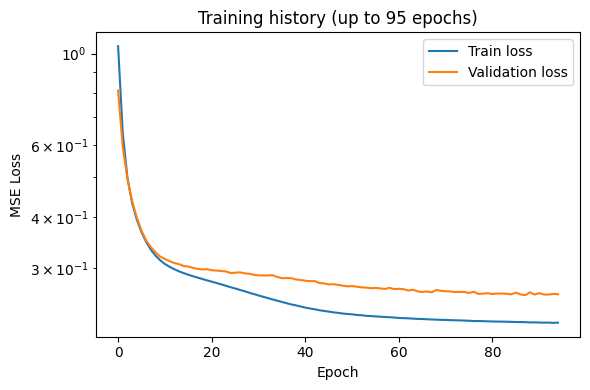


🔍 Evaluating model after 95 epochs...
Loaded model from: checkpoints\model_epoch_95.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.029947  0.173053  0.070854  0.761456

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000541   0.000371   0.984171
Linear Velocity   0.000305   0.017471   0.013407   0.583893
         Angles   0.000023   0.004779   0.003583   0.981422
  Angular Rates   0.119462   0.345632   0.266055   0.496339
📊 Logged metrics: Epoch 95 | MSE = 2.994750e-02, R2 = 0.761456

🟢 Training up to 100 / 100 epochs...

Epoch 1/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.2251
Epoch 1: val_loss improved from None to 0.26168, saving model to checkpoints/best_model_until_100.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2210 - val_loss: 0.2617 - learning_rate: 0.0010
Epoch 2/5
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2329 
Epoch 2: val_loss improved from 0.2

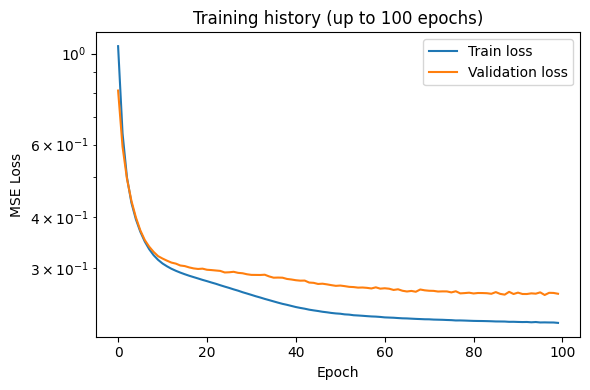


🔍 Evaluating model after 100 epochs...
Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030166  0.173682  0.071181  0.760172

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000539   0.000369   0.983821
Linear Velocity   0.000308   0.017558   0.013507   0.582879
         Angles   0.000023   0.004764   0.003582   0.981674
  Angular Rates   0.120331   0.346888   0.267267   0.492315
📊 Logged metrics: Epoch 100 | MSE = 3.016559e-02, R2 = 0.760172

💾 All experiment parameters and results saved to:
checkpoints\3_no_shuffle.json

📈 Performance summary:
    epochs                         model_path       MSE        R2
0        5    checkpoints\model_epoch_5.keras  0.040556  0.618997
1       10   checkpoints\model_epoch_10.keras  0.037798  0.684739
2       15   checkpoints\model_epoch_15.keras  0.037039  0.699237
3       20   checkpoints\model_epo

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import joblib
import pandas as pd

# --- Configuration ---
total_epochs = 100
eval_interval = 5    # evaluate every 100 epochs
batch_size = 128
save_dir = "checkpoints"

os.makedirs(save_dir, exist_ok=True)

# --- Global experiment configuration dictionary ---
experiment_params = {
    "dataset_split" : "Training set shuffled",
    "randdom_seed" : random_seed ,
    "model_name": "MLP",
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "total_epochs": total_epochs,
    "eval_interval": eval_interval,
    "data_file": file_path,
    "model_summary" : layer_sizes,
    "results": []  # will be filled dynamically
    
}

# --- Callbacks ---
def make_callbacks(current_epoch):
    """Create callbacks for the current training chunk."""
    return [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f"{save_dir}/best_model_until_{current_epoch}.keras",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

# --- Save scalers once ---
joblib.dump(sc_in, f"{save_dir}/sc_in.joblib")
joblib.dump(sc_out, f"{save_dir}/sc_out.joblib")

# --- Initialize training record ---
history_all = {'loss': [], 'val_loss': []}

# --- Training and evaluation loop ---
for current_epoch in range(eval_interval, total_epochs + 1, eval_interval):
    print(f"\n🟢 Training up to {current_epoch} / {total_epochs} epochs...\n")

    # Train for eval_interval epochs (continues from current weights)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=eval_interval,
        batch_size=batch_size,
        verbose=1,
        callbacks=make_callbacks(current_epoch),
        shuffle=True
    )

    # --- Update training history ---
    history_all['loss'].extend(history.history['loss'])
    history_all['val_loss'].extend(history.history['val_loss'])

    # --- Save model manually every eval_interval ---
    model_save_path = os.path.join(save_dir, f"model_epoch_{current_epoch}.keras")
    model.save(model_save_path)
    print(f"💾 Model saved at {model_save_path}")

    # --- Best epoch so far ---
    best_epoch = np.argmin(history_all['val_loss']) + 1
    best_val_loss = np.min(history_all['val_loss'])
    print(f"\n🏆 Best epoch so far: {best_epoch} with val_loss = {best_val_loss:.6f}\n")

    # --- Plot training history ---
    plt.figure(figsize=(6, 4))
    plt.plot(history_all['loss'], label='Train loss')
    plt.plot(history_all['val_loss'], label='Validation loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'Training history (up to {current_epoch} epochs)')
    plt.tight_layout()
    plt.show()

    # --- Evaluate model ---
    print(f"\n🔍 Evaluating model after {current_epoch} epochs...")
    results = test_keras_model_grouped(
        model_path=model_save_path,   # evaluate the just-saved model
        X_test=X_test,
        Y_test=Y_test,
        sc_out=sc_out,
        plot_dim=0
    )

    # --- Extract metrics ---
    mse = float(results["overall"]["MSE"])
    r2 = float(results["overall"]["R2"])

    experiment_params["results"].append({
        "epochs": current_epoch,
        "model_path": model_save_path,
        "MSE": mse,
        "R2": r2
    })

    print(f"📊 Logged metrics: Epoch {current_epoch} | MSE = {mse:.6e}, R2 = {r2:.6f}")

# --- Save the entire experiment dictionary as JSON ---
json_path = os.path.join(save_dir, "4_all_shuffled.json")
with open(json_path, "w") as f:
    json.dump(experiment_params, f, indent=4)

print(f"\n💾 All experiment parameters and results saved to:\n{json_path}")

# --- Optional: show quick summary ---
df_results = pd.DataFrame(experiment_params["results"])
print("\n📈 Performance summary:")
print(df_results)


## Training performance
We can observe that our model conserves a very good capability of abstraction while on the other hand is very performative to learn

Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030166  0.173682  0.071181  0.760172

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000539   0.000369   0.983821
Linear Velocity   0.000308   0.017558   0.013507   0.582879
         Angles   0.000023   0.004764   0.003582   0.981674
  Angular Rates   0.120331   0.346888   0.267267   0.492315


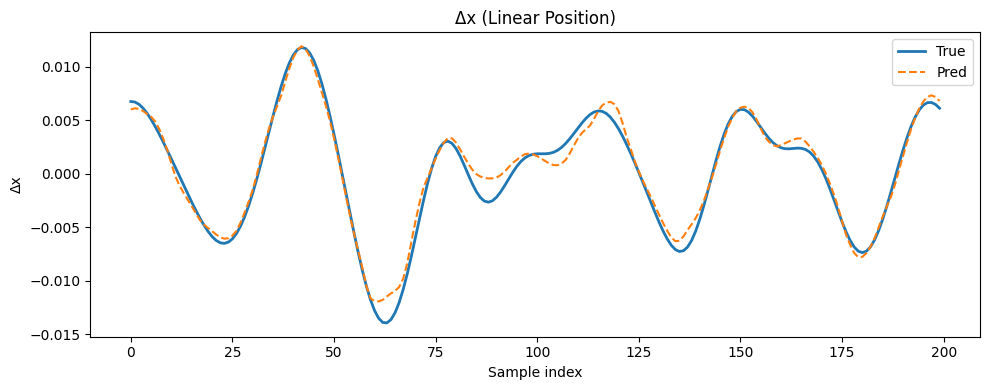

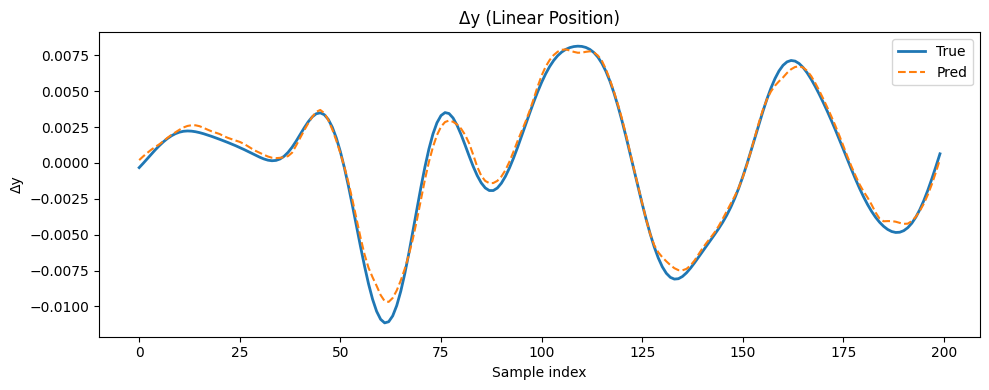

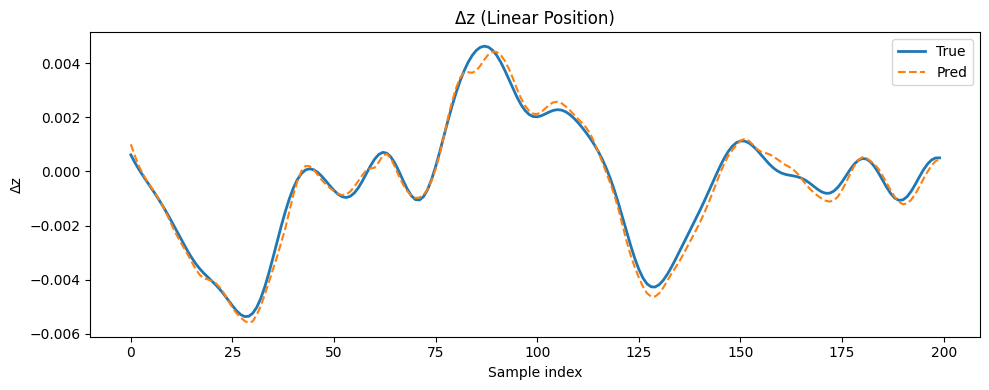

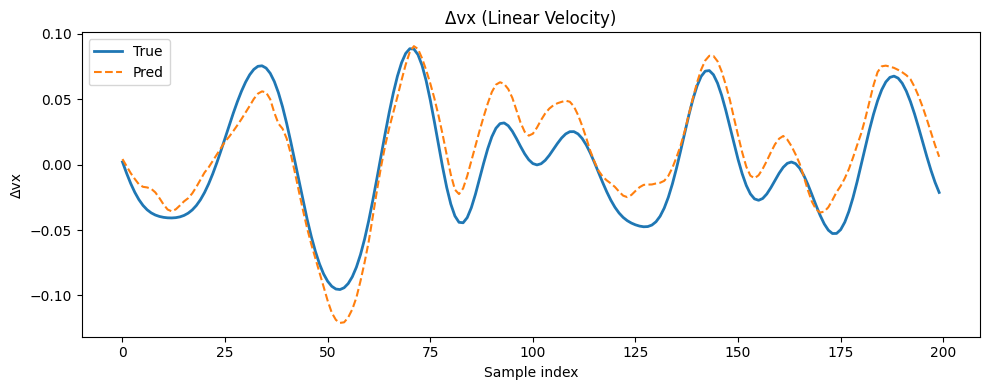

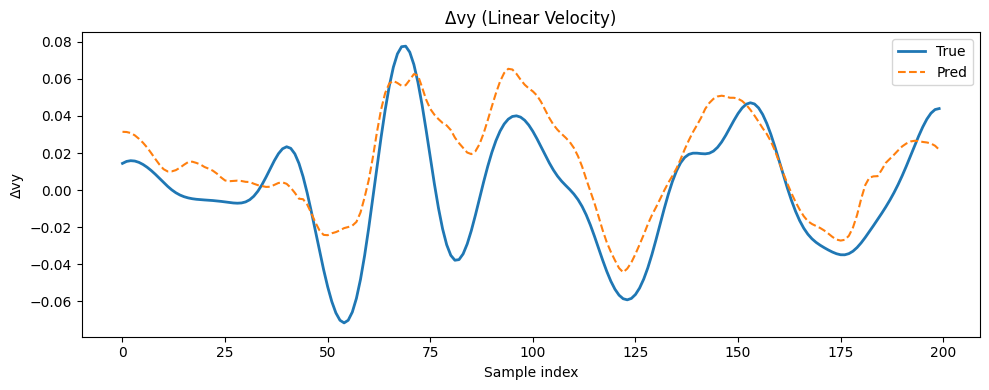

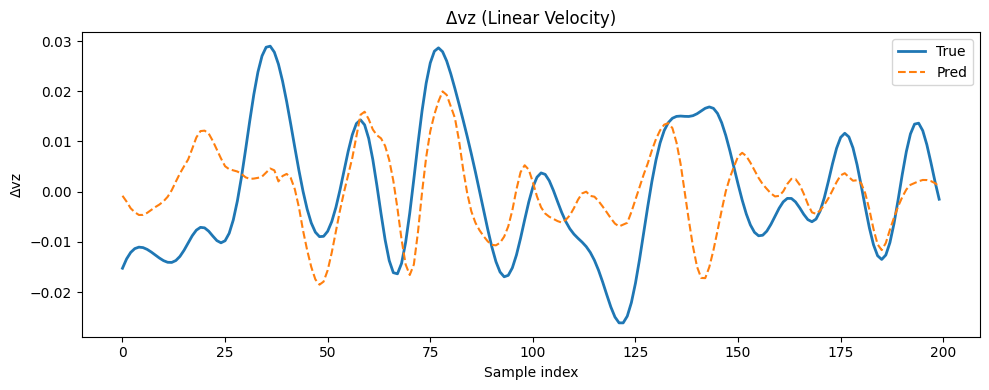

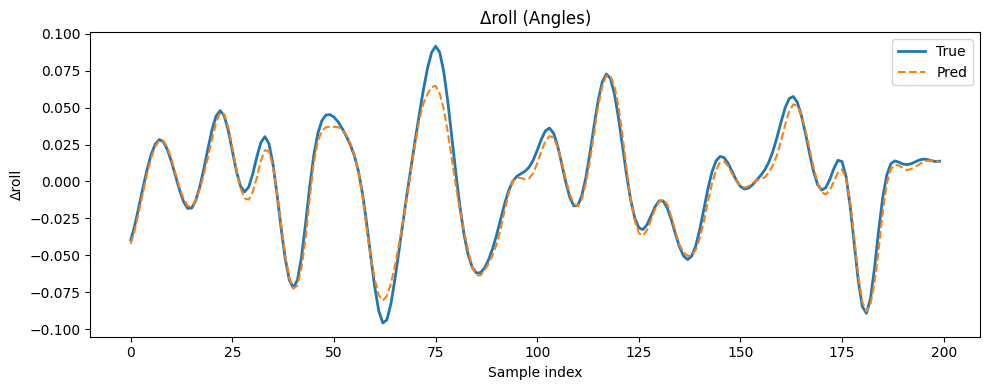

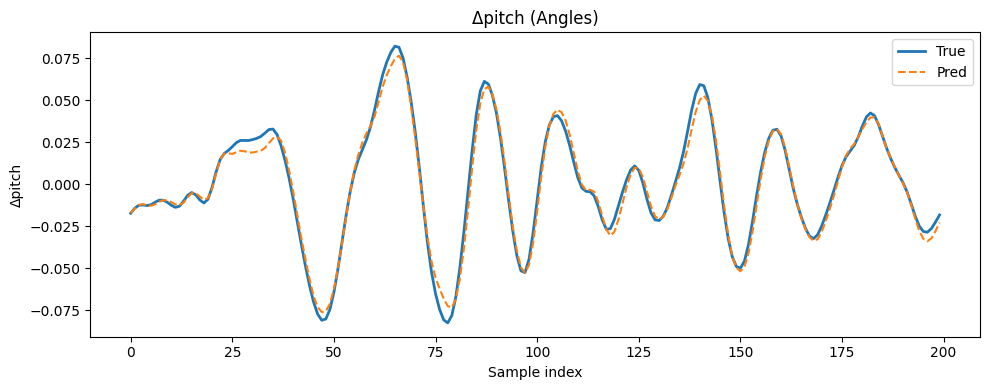

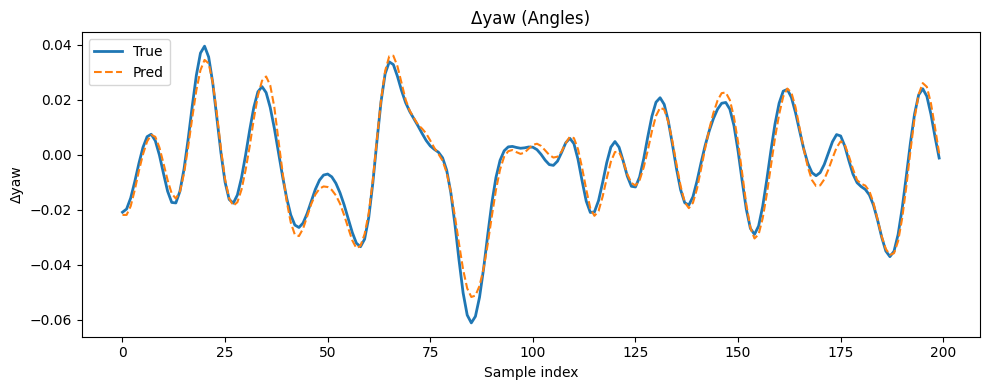

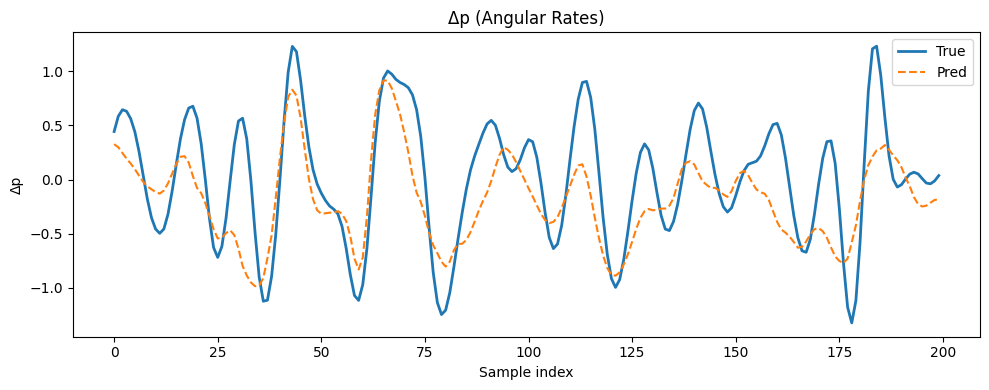

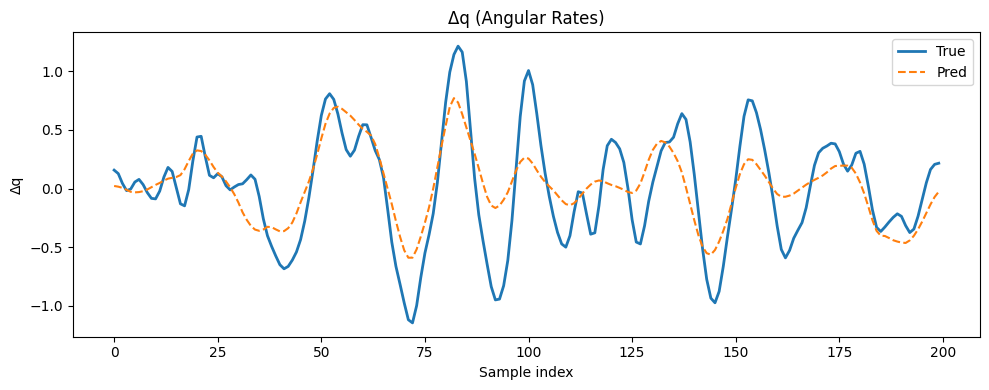

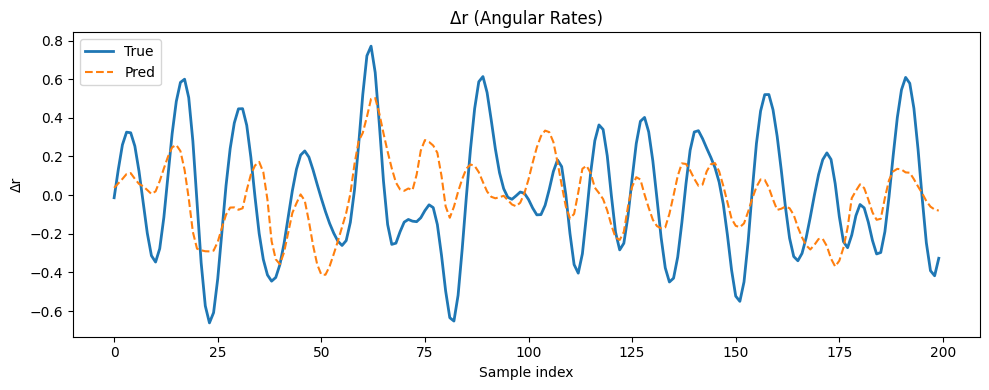

In [27]:
model_path="checkpoints\model_epoch_100.keras"

results3 = test_keras_model_grouped(
    model_path= model_path,
    X_test=X_test,
    Y_test=Y_test,
    sc_out=sc_out,
    plot_dim=12   # number of output dimensions to plot
)

## Testing performances
We have no data left for evaluating a rollout since the test set is composed by shuffled data. Selecting random indices for the training, validation and test set made the net very performative (almost 100%) at understanding the evolution deltaX of the system's dynamics, but makes it impossible to evaluate an open loop rollout on an ordered test set.

Plot limited to first 2.000s (200 samples).


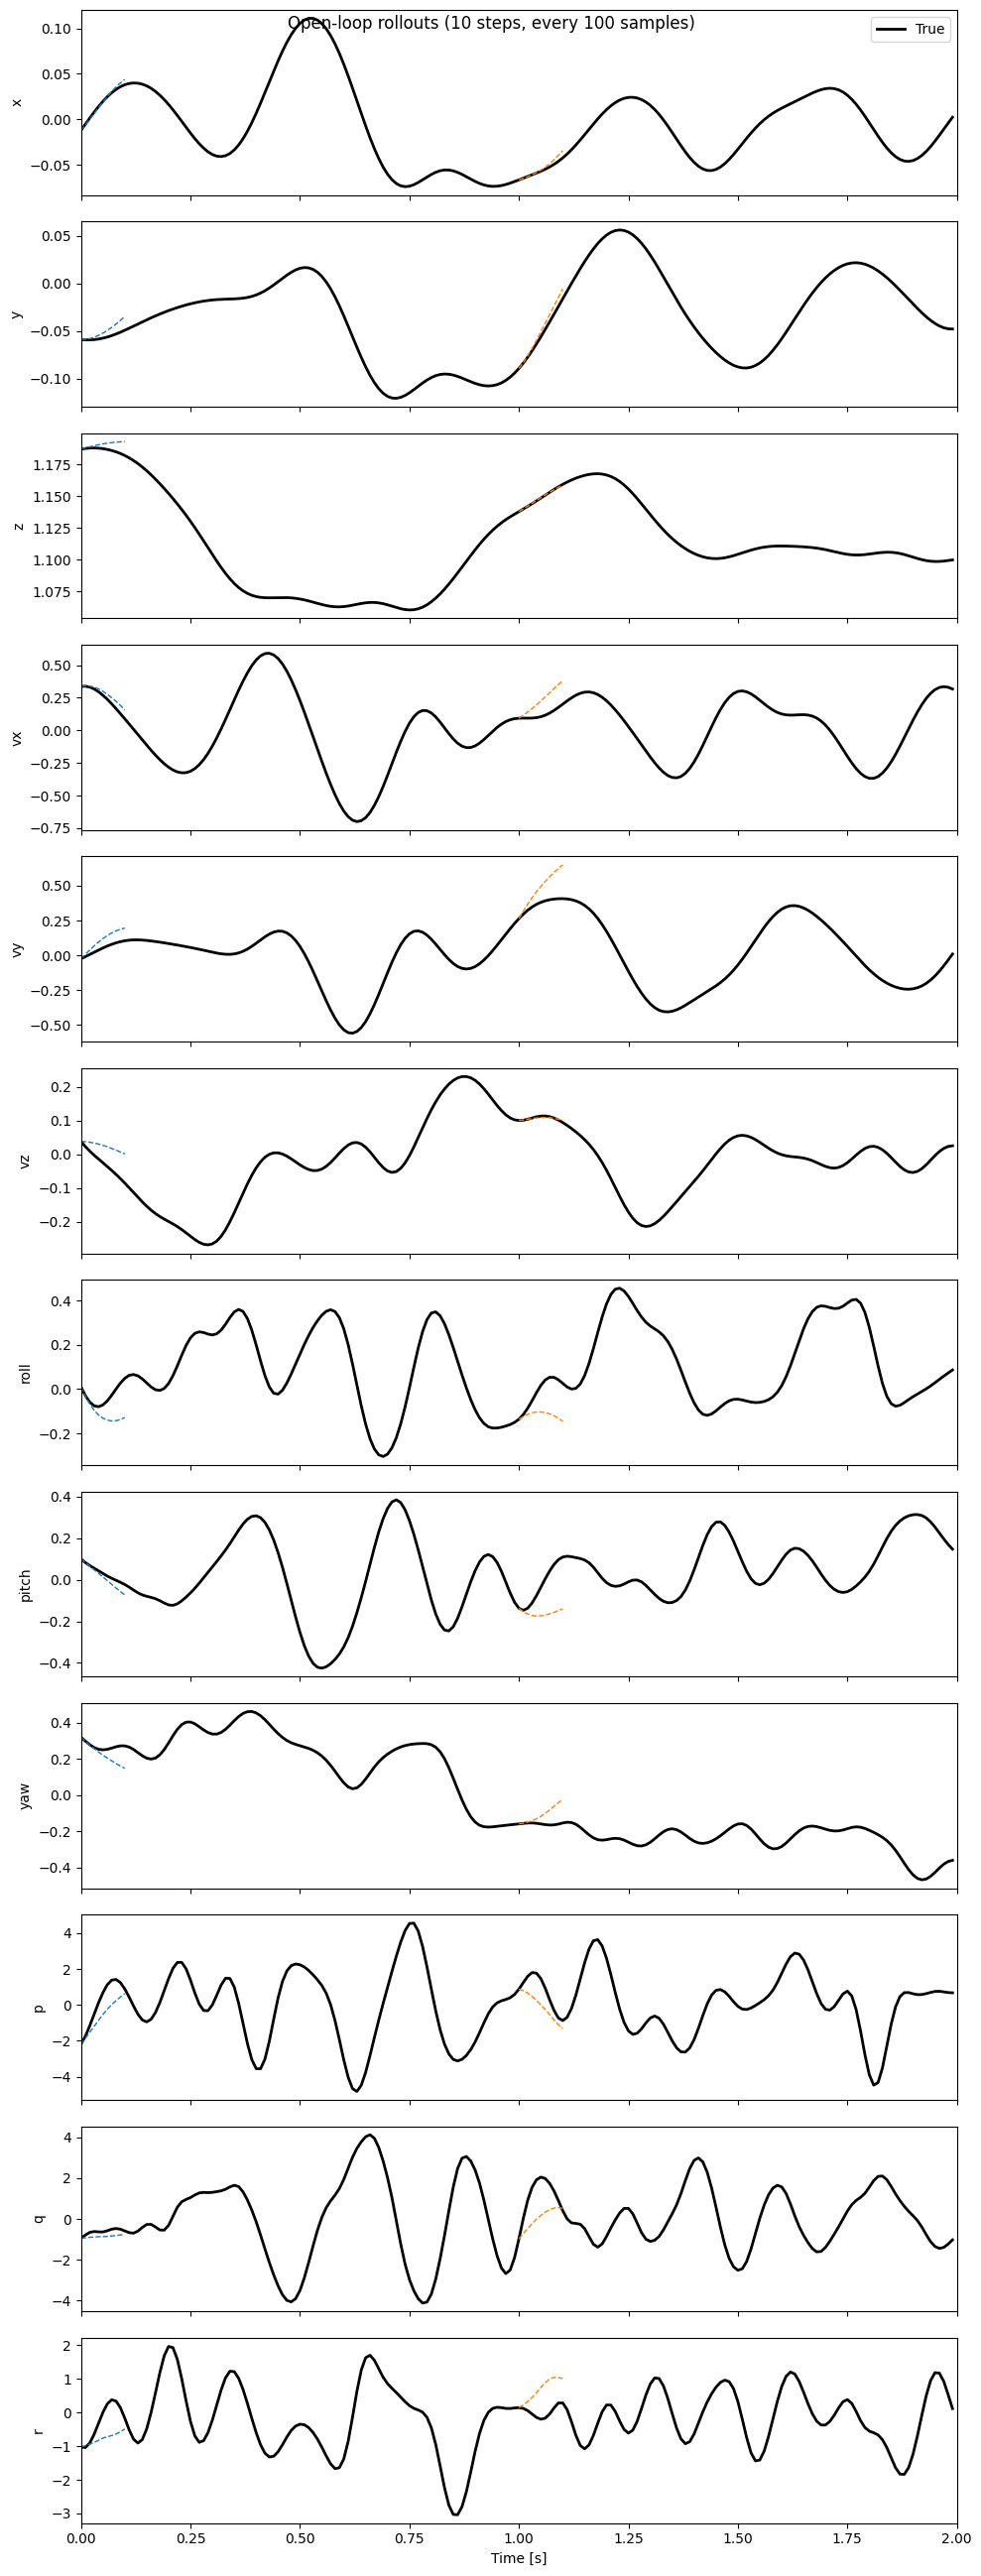


--- Open-loop horizon metrics (physical units) ---
MSE:  5.034756e-02
RMSE: 2.243826e-01
MAE:  1.528347e-01
R2:   -20.110778


In [28]:
def inv_transform_cols(sc, Xn_part, col_start):
    """Inverse-transform selected columns from a fitted StandardScaler."""
    cols = slice(col_start, col_start + Xn_part.shape[1])
    return Xn_part * sc.scale_[cols] + sc.mean_[cols]

def transform_cols(sc, X_part, col_start):
    """Transform selected columns using the fitted StandardScaler."""
    cols = slice(col_start, col_start + X_part.shape[1])
    return (X_part - sc.mean_[cols]) / sc.scale_[cols]

def get_test_states_inputs_physical(X_test, sc_in, n_x):
    """
    From normalized X_test = [X_n, U_n], recover physical X_test_state and U_test.
    """
    Xn_state = X_test[:, :n_x]
    Xn_input = X_test[:, n_x:]
    X_state_phys = inv_transform_cols(sc_in, Xn_state, 0)
    U_phys       = inv_transform_cols(sc_in, Xn_input, n_x)
    return X_state_phys, U_phys


def rollout_openloop_model(
    model, X_test, sc_in, sc_out,
    n_x, n_u, dt=0.01, N_pred=5, stride=50,
    state_labels=None, plot_dim=None, max_plot_pts=200,
    t_max=None    # ← max time (in seconds) to display
):
    """
    Open-loop rollout on the TEST set (no shuffling), consistent with training:
    - keeps x in physical units,
    - builds normalized input with sc_in,
    - predicts Δx in normalized units, denormalizes with sc_out,
    - updates x_phys += Δx_phys,
    - optionally limits plots to t_max seconds (x-axis in real time).
    """

    # --- Denormalize test states and inputs ---
    X_phys, U_phys = get_test_states_inputs_physical(X_test, sc_in, n_x)
    N = len(X_phys)

    if state_labels is None:
        state_labels = [f"x{i+1}" for i in range(n_x)]
    if plot_dim is None:
        plot_dim = n_x

    # --- Build time vector ---
    t = np.arange(N) * dt

    # --- Optional limit for plotting only ---
    if t_max is not None:
        max_idx = np.searchsorted(t, t_max)
        X_phys = X_phys[:max_idx]
        U_phys = U_phys[:max_idx]
        t = t[:max_idx]
        N = len(X_phys)
        print(f"Plot limited to first {t_max:.3f}s ({N} samples).")

    # --- Plot true trajectories ---
    fig, axes = plt.subplots(n_x, 1, figsize=(10, 2.2 * n_x), sharex=True)
    if n_x == 1:
        axes = [axes]

    for i in range(n_x):
        axes[i].plot(t, X_phys[:, i], "k-", lw=2, label="True")
        axes[i].set_ylabel(state_labels[i])

    # --- Perform rollouts ---
    for k0 in range(0, N - N_pred, stride):
        x_phys = X_phys[k0].copy()
        traj_pred = [x_phys.copy()]

        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]

            # Build normalized input [x,u]
            x_n = transform_cols(sc_in, x_phys.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)

            # Predict Δx and update physical state
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_phys = x_phys + delta_x_phys.ravel()
            traj_pred.append(x_phys.copy())

        traj_pred = np.array(traj_pred)
        t_pred = t[k0 : k0 + len(traj_pred)]

        for i in range(min(plot_dim, n_x)):
            axes[i].plot(
                t_pred[:max_plot_pts],
                traj_pred[:max_plot_pts, i],
                "--", lw=1
            )

    # --- Axis labels, limits, and formatting ---
    axes[-1].set_xlabel("Time [s]")
    for ax in axes:
        if t_max is not None:
            ax.set_xlim(0, t_max)
    axes[0].legend()

    fig.suptitle(f"Open-loop rollouts ({N_pred} steps, every {stride} samples)")
    plt.tight_layout()
    plt.show()

    # --- Metrics computation (unchanged) ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    Y_true_list, Y_pred_list = [], []
    for k0 in range(0, N - N_pred, stride):
        x_pred = X_phys[k0].copy()
        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]
            x_n = transform_cols(sc_in, x_pred.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_pred = x_pred + delta_x_phys.ravel()
        Y_pred_list.append(x_pred)
        Y_true_list.append(X_phys[k0 + N_pred])

    if Y_true_list:
        Y_true = np.vstack(Y_true_list)
        Y_pred = np.vstack(Y_pred_list)

        mse = mean_squared_error(Y_true, Y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_true, Y_pred)
        r2 = r2_score(Y_true, Y_pred)

        print("\n--- Open-loop horizon metrics (physical units) ---")
        print(f"MSE:  {mse:.6e}")
        print(f"RMSE: {rmse:.6e}")
        print(f"MAE:  {mae:.6e}")
        print(f"R2:   {r2:.6f}")

        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    else:
        print("Not enough samples to compute horizon metrics.")
        return None


n_x = Y_test.shape[1]
n_u = X_test.shape[1] - n_x

metrics = rollout_openloop_model(
    model=load_model(model_path),
    X_test=X_test,
    sc_in=sc_in,
    sc_out=sc_out,
    n_x=n_x,
    n_u=n_u,
    dt=0.01,
    N_pred=10,
    stride=100,
    t_max=2.0,   # <-- plot only first 2 seconds
    state_labels=["x","y","z","vx","vy","vz","roll","pitch","yaw","p","q","r"],
    plot_dim=12
)
